In [1]:
#!/usr/bin/env python3
import tensorflow as tf

import os

import matplotlib.pyplot as plt 
import matplotlib
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates
from matplotlib.ticker import FixedLocator, FixedFormatter, FuncFormatter, MultipleLocator

import numpy as np
import pandas as pd

import json

from src.ForecastModel.data.models import DataModelCV
from src.ForecastModel.utils.metrics import eval_peak_distance, calculate_rms
from src.ForecastModel.utils.losses import loss_peak_mse
from src.ForecastModel.utils.postprocessing import ModelHandler

plt.rcParams.update({
    "text.usetex": False,
    'font.size'   : 8,
})


In [2]:
# helper functions
def get_n_peaks(df, col_eval, n_peaks, window):
    # find the n_peaks most prominent peaks in df[col_eval] and returns peak values with the window
    peaks = []
    df_length = df.shape[0]
    for n_peak in range(n_peaks):
        i_max   = df[col_eval].argmax()
        i_start = np.max([0, i_max - window//4])
        i_end   = np.min([df_length, i_max + window])
        
        df["n_peak"] = n_peak
        peaks.append(df.iloc[i_start:i_end].copy())
        
        df = df.drop(df.index[i_start:i_end], axis=0)
    
    peaks = pd.concat(peaks, axis=0)
    return peaks

def dt(dates, format="%d/%m/%Y %H:%M"):
    if dates.tz == None:
        # make TZ aware
        return pd.to_datetime(dates, format=format).tz_localize("Europe/London").tz_convert("UTC")
    else:
        return pd.to_datetime(dates, format=format).tz_convert("UTC")

In [3]:
PLOT_PATH          = r"plots"
DATA_PATH          = r"src\data\Dataset.csv"
CROSS_INDICES_PATH = r"src\data\indices"

In [4]:
models = {       
    "arima-boxcox": ModelHandler("ARIMA-BOXCOX",
                r"rst\ARIMA-BOXCOX",
                is_final_model = True,
                is_external_model = True,
                color = "#E69F00",
                ls = "--",
                  ),
    "arima": ModelHandler("ARIMA",
                r"rst\ARIMA",
                is_final_model = True,
                is_external_model = True,
                color = "#E69F00",
                ls = "--",
                  ),

    "arimax": ModelHandler("ARIMAX",
                r"rst\ARIMAX",
                is_final_model = True,
                is_external_model = True,
                color = "#0072B2",
                ls = "--",
                  ),

     "pbhm-hlstm": ModelHandler("PBHM-HLSTM",
                   r"rst\PBHM-HLSTM",
                   is_final_model = True,
                   color = "#56B4E9",
                   ls = "-",
                 ),
     "elstm": ModelHandler("eLSTM",
                   r"rst\eLSTM",
                   is_final_model = True,
                   color = "#D55E00",
                   ls = "-",
                 ),
     "lstm": ModelHandler("LSTM",
                   r"rst\LSTM",
                   is_final_model = True,
                   color = "#CC79A7",
                   ls = "-",
                 ),
     }


## analyse peak events

In [5]:
num_peaks_per_fold = 2    # number of peaks per fold to analyze
load_predictions   = False # load predictions or newly predict with models

arima-boxcox
extract peaks from model
dictonary loaded
extracting peaks from fold 0
extracting peaks from fold 1
extracting peaks from fold 2
extracting peaks from fold 3
extracting peaks from fold 4
processing fold 2
processing fold 3
processing fold 4
processing fold 5
processing fold 6


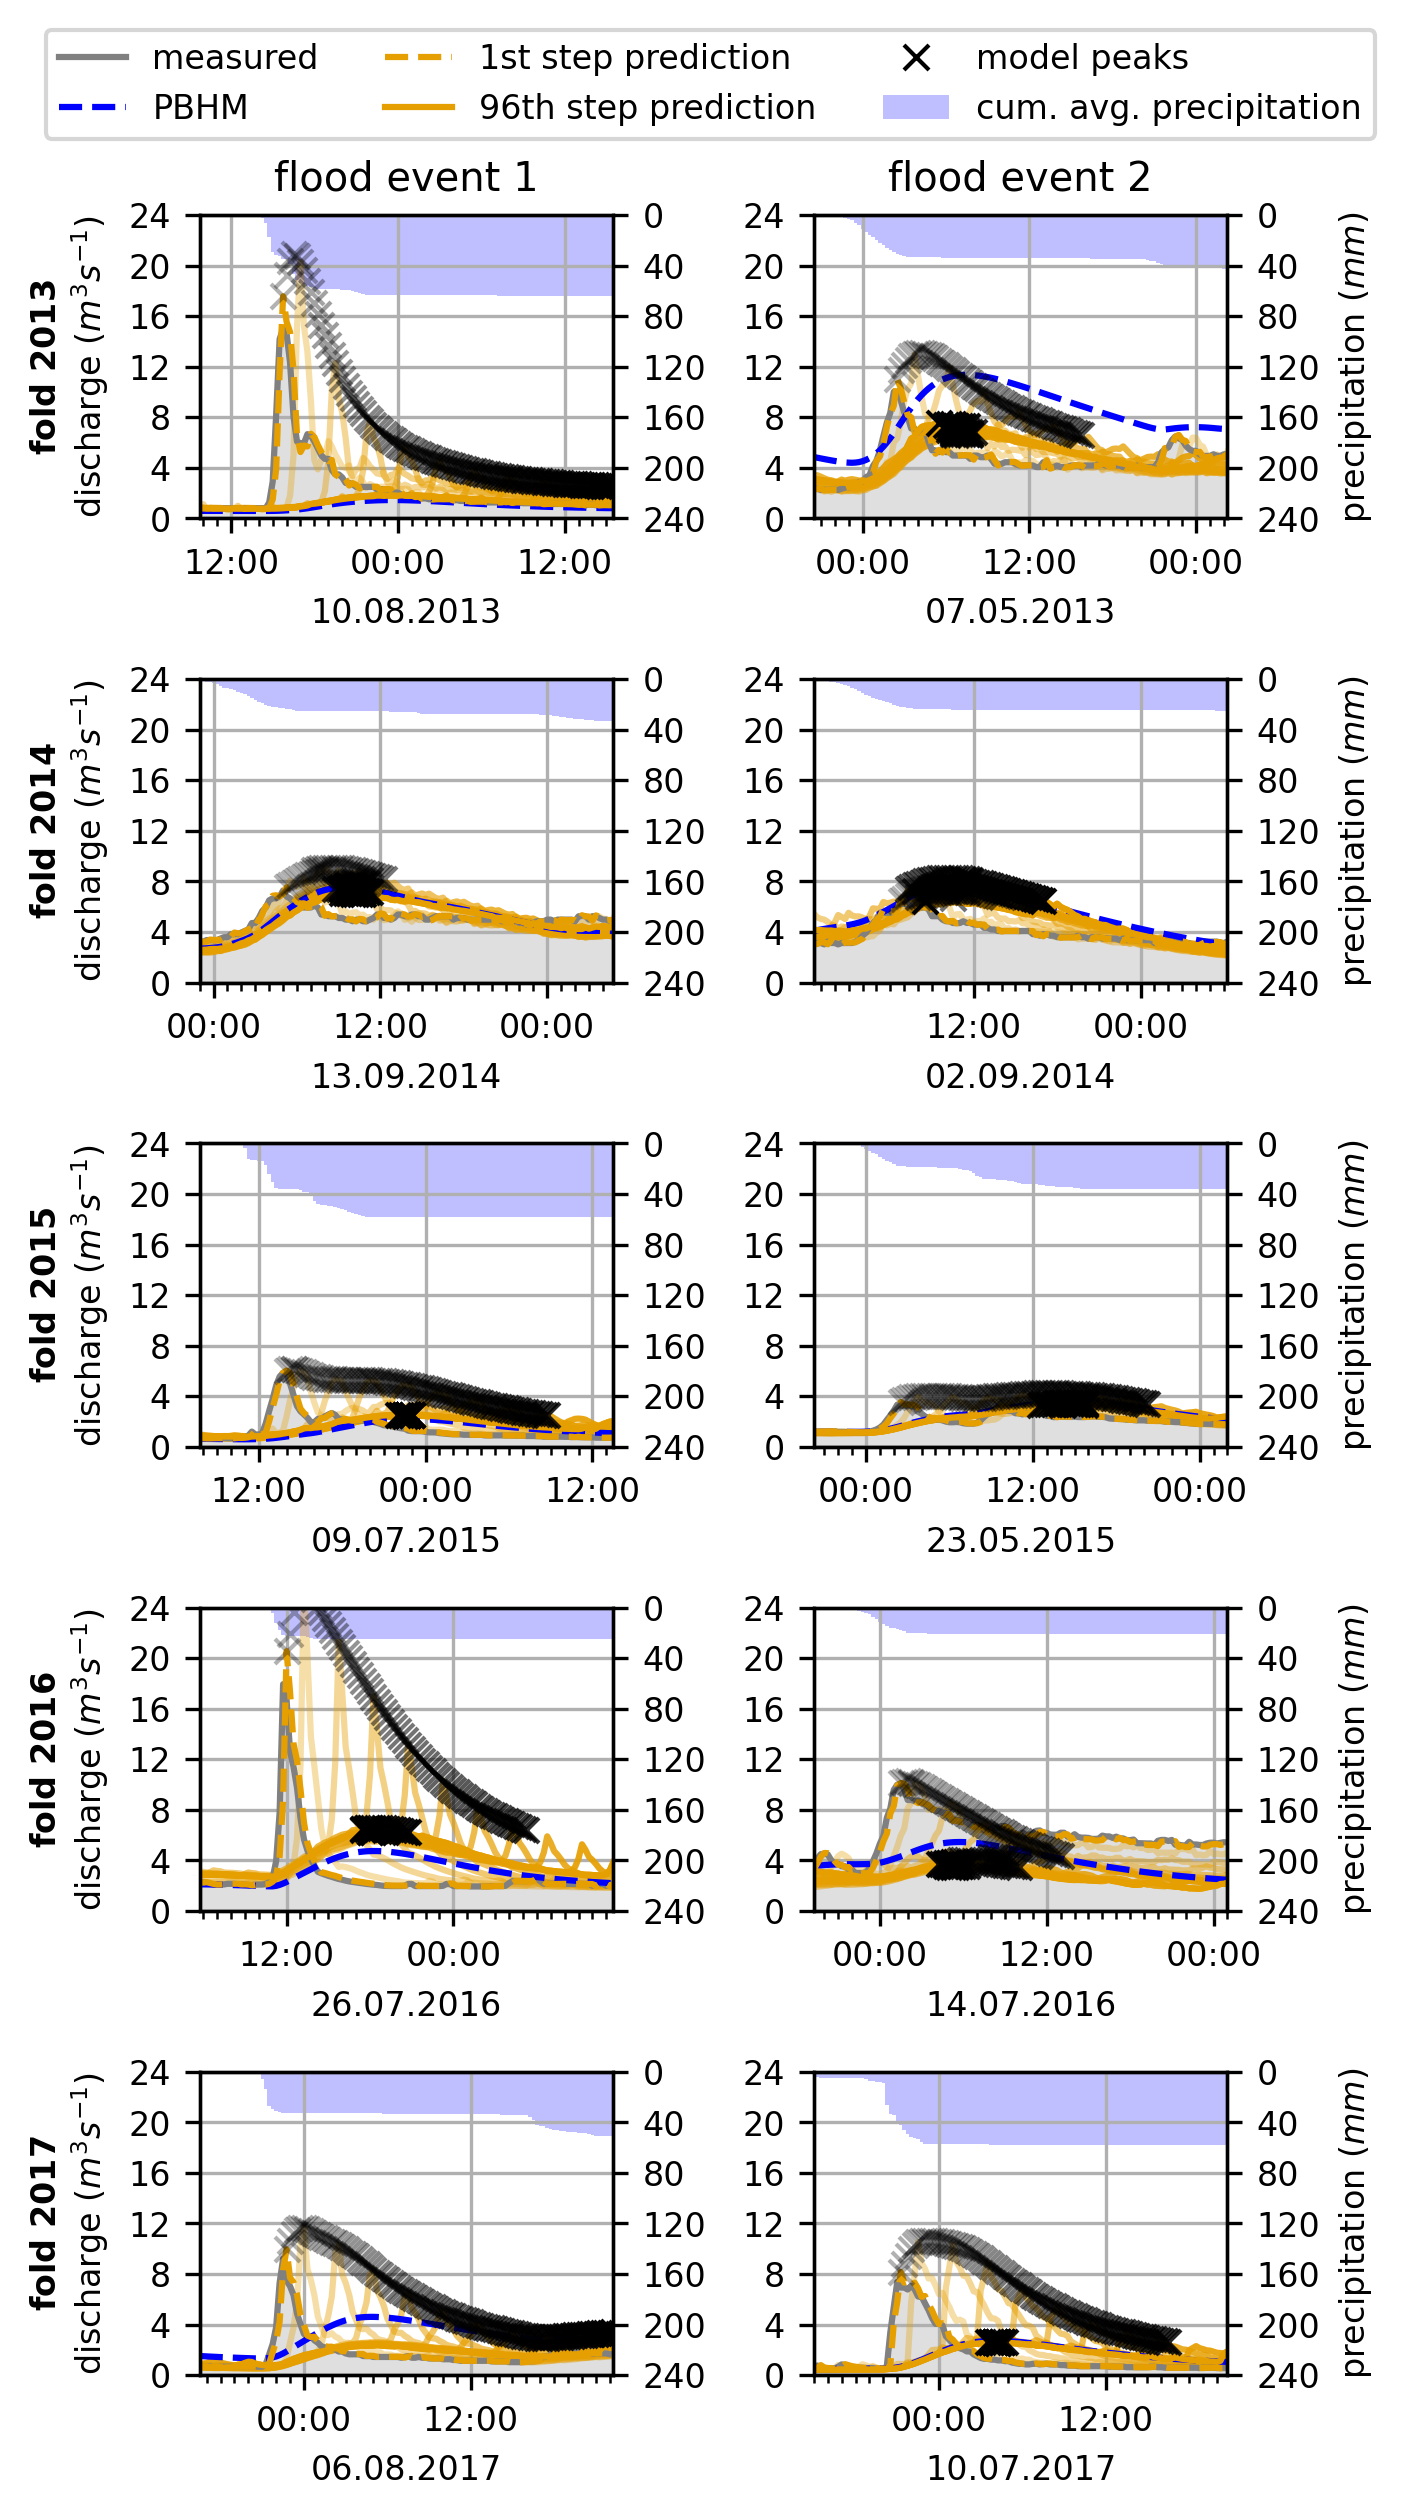

arima
extract peaks from model
dictonary loaded
extracting peaks from fold 0
extracting peaks from fold 1


In [ ]:
idx = -10
dfp = pd.DataFrame(columns = ["name", "year", "peak", 
                              "peak_flow", "total_flow",
                              "hyd_perr", "hyd_poff",
                              "rms_hyd", "flow_hyd", 
                              "rms_0", "rms_m", "rms_95",
                              "flow_0", "flow_m", "flow_95"]
                   
                        ) 
dfp = dfp.astype(dtype= {"name"     :"str",     "year"      :"int32",    "peak"  : "int32", 
                         "peak_flow":"float64", "total_flow":"float64",
                         "hyd_perr" :"float64", "hyd_poff"  :"float64",
                         "rms_hyd"  :"float64", "flow_hyd"  :"float64", 
                         "rms_0"    :"float64", "rms_m"     :"float64", "rms_95" : "float64",
                         "flow_0"   :"float64", "flow_m"    :"float64", "flow_95": "float64"}
                )

for n, key in enumerate(models.keys()):
    idx += 10
    print(key)
    fig, axes = plt.subplots(5, num_peaks_per_fold, figsize=(4.72,8), dpi=300)
    eval_path = os.path.join(models[key].hp_path, "eval_peaks.pkl")
    
    if (~os.path.exists(eval_path)) | (load_predictions == False):
        print("extract peaks from model")
        eval_peaks = []

        # load datamodel
        dm = DataModelCV(DATA_PATH,
               target_name       = models[key].target_name,
               hincast_features  = models[key].feat_hindcast,
               forecast_features = models[key].feat_forecast,
             )

        if models[key].is_external_model:
            overlap_length = 0
            hindcast_length = 96
        else:
            # load trial data
            with open(os.path.join(models[key].hp_path, "trial.json")) as f:
                trial = json.load(f)

            hindcast_length = trial['hyperparameters']['values']['hindcast_length']
            try:
                overlap_length = trial['hyperparameters']['values']['osc_length']
            except:
                overlap_length = 0 

        dm.main(os.path.join(CROSS_INDICES_PATH, f"cross_indices_{hindcast_length}.pkl"))

        for n_fold in dm.cross_sets.keys():
            print(f"extracting peaks from fold {n_fold}")
            year = 2013 + n_fold

            # load dataset
            X, y  = dm.getDataSet(dm.cross_sets[n_fold]["test"], scale=True) 

            # get hydrologial model 
            s = dm.getFeatureSet(n_fold+2, "qsim")[2]
            df = pd.DataFrame({'index':dt(s.index), 'qhyd':s.values}).set_index("index")

            # add ground truth
            s = dm.getFeatureSet(n_fold+2, "qmeasval")[2]
            s.index = dt(s.index)
            df = df.merge(s.rename("qmeas").to_frame(), left_index=True, right_index=True)

            if models[key].is_external_model:
                
                ext_df = pd.read_pickle(os.path.join(models[key].hp_path, f"forecast_{year}.pkl"))

                ext_df.index = pd.date_range(ext_df.index[0], ext_df.index[-1], freq="15min", tz="UTC")
                
                forecasts_df = ext_df[[f"fc{x:d}" for x in range(96)]].copy()
                forecasts_df.columns = [f"q{x:d}" for x in range(96)]

                del ext_df
                
            else:
                # load model
                tf.keras.backend.clear_session()
                model  = tf.keras.models.load_model(os.path.join(models[key].hp_path, f"model_fold_{n_fold:d}.keras"),
                                               custom_objects={'peak_loss'    : loss_peak_mse, # dummy as no costum functions are saved by keras
                                                              'kge_nse_loss'  : loss_peak_mse, #
                                                              'loss_nkge_nnse': loss_peak_mse, #
                                                              })

                yp = model.predict(X, batch_size=1000)
                
                if key == "lstm_residual":
                    _, _, yidx = dm.sets[dm.cross_sets[n_fold]["test"]]
                    simu = dm.getWithIndexArray(["qsim"], yidx)
            
                    # get real values from residuals
                    yp += simu[:,:,0]
            
                forecasts_df = pd.DataFrame(data    = yp, 
                                        columns = [f"q{x:d}" for x in range(yp.shape[1])],
                                        index   = dt(dm.getTimeSet(n_fold+2, 0)[2]))

                # save dataframe 
                df_out = forecasts_df.copy()
                df_out.index = pd.to_datetime(df_out.index, format="%d/%m/%Y %H:%M", utc=True)
                df_out.to_pickle(os.path.join(models[key].hp_path, f"forecast_{year}.pkl"))
            
            
            # get forcasting stats                          
            for forecast_step in range(1, forecasts_df.shape[1]):
                forecasts_df[f"q{forecast_step:d}"] = forecasts_df[f"q{forecast_step:d}"].shift(forecast_step)
            
            # merge model predctions
            df = df.merge(forecasts_df, left_index=True, right_index=True)  
            
            # merge prcipitation
            s = pd.Series(dm.getFeatureSet(n_fold+2, "pmean", 0)[2].values, dt(dm.getTimeSet(n_fold+2, 0)[2]))
            df = df.merge(s.rename("pmean").to_frame(), left_index=True, right_index=True)
            
            forecasts_df.dropna(inplace=True)
            stats_df = pd.DataFrame(columns = ["fmin", "fmax", "fmean", 
                                               "fq95", "fq90", "fq75",
                                               "fq50",
                                               "fq25", "fq10", "fq5"],
                                   index = forecasts_df.index)
            
            for i, row in forecasts_df.iterrows():
                stats_df.loc[i] = [row.values.min(), row.values.max(), row.values.mean()] + \
                                        [np.quantile(row.values, float(x[2:])/100) for x in stats_df.columns[3:]]
                  
            # merge stats
            df = df.merge(stats_df, left_index=True, right_index=True)        
            df.dropna(inplace=True)
                                           
            peaks = get_n_peaks(df, "qmeas", num_peaks_per_fold, 24*4)
            peaks["n_fold"] = n_fold + 2

            # add to summary
            eval_peaks.append(peaks)

        # save data to pickle
        df = pd.concat(eval_peaks, axis=0)
        df.to_pickle(eval_path)

    df = pd.read_pickle(eval_path)
    for n_fold in df.n_fold.unique().tolist():
        print(f"processing fold {n_fold}")
        peaks = df[df.n_fold == n_fold]
        for p in range(num_peaks_per_fold):
            
            dt_index = pd.to_datetime(peaks[peaks.n_peak == p]["qmeas"].index, format="%d/%m/%Y %H:%M", utc=True)
            timestep = dt_index[1] - dt_index[0]
            
            axes[n_fold-2, p].grid("on")
            
            # add precipitation bars
            axes[n_fold-2, p].bar(dt_index, 
                                 - 0.1 * np.cumsum(peaks[peaks.n_peak == p]["pmean"].values.astype(np.float64)),
                                 timestep, 24,
                                 label="cum. avg. precipitation",
                                 color= "b",
                                 alpha = 0.25,
                                 )
            axes2 = axes[n_fold-2, p].twinx()
            axes2.set_yticks(np.arange(240,-1,-40))
            axes2.invert_yaxis()

            # eval peaks
            idx_peak  = peaks[peaks.n_peak == p]["qmeas"].argmax()
            peak_flow = peaks[peaks.n_peak == p]["qmeas"].max()
            dfp.loc[idx+n_fold+5*p, ["hyd_perr", "hyd_poff"]] = [peaks[peaks.n_peak == p]["qhyd"].max() - peak_flow,
                                                                 peaks[peaks.n_peak == p]["qhyd"].argmax() - idx_peak,
                                                                ]
            dfp.loc[idx+n_fold+5*p, [f"perr_{x}" for x in range(96)]] = [peaks[peaks.n_peak == p][f"q{x}"].max() - peak_flow for x in range(96)]
            dfp.loc[idx+n_fold+5*p, [f"poff_{x}" for x in range(96)]] = [peaks[peaks.n_peak == p][f"q{x}"].argmax() - idx_peak for x in range(96)]

            # eval section
            rms_q0 = calculate_rms(peaks[peaks.n_peak == p]["qmeas"].values, 
                                    peaks[peaks.n_peak == p]["q0"].values)
            rms_qm = calculate_rms(peaks[peaks.n_peak == p]["qmeas"].values, 
                                    peaks[peaks.n_peak == p]["fmean"].values)
            rms_q95 = calculate_rms(peaks[peaks.n_peak == p]["qmeas"].values, 
                                    peaks[peaks.n_peak == p]["q95"].values)
            rms_hyd = calculate_rms(peaks[peaks.n_peak == p]["qmeas"].values, 
                                    peaks[peaks.n_peak == p]["qhyd"].values)
            
            peak_flow = peaks[peaks.n_peak == p]["qmeas"].max()
            
            dfp.loc[idx+n_fold+5*p, ["name", "year", "peak"]] = [models[key].name, np.int32(2011+n_fold), np.int32(p)]
            dfp.loc[idx+n_fold+5*p, ["peak_flow", "total_flow"]] = [peak_flow, peaks[peaks.n_peak == p]["qmeas"].sum()]
            dfp.loc[idx+n_fold+5*p, ["rms_hyd", "flow_hyd"]] = [rms_hyd,  peaks[peaks.n_peak == p]["qhyd"].sum()]
            dfp.loc[idx+n_fold+5*p, ["rms_0", "rms_m", "rms_95"]] = [rms_q0, rms_qm, rms_q95]
            dfp.loc[idx+n_fold+5*p, ["flow_0", "flow_m", "flow_95"]] = [peaks[peaks.n_peak == p]["q0"].sum(),
                                                                     peaks[peaks.n_peak == p]["fmean"].sum(),
                                                                     peaks[peaks.n_peak == p]["q95"].sum(),
                                                                    ]
            
            axes[n_fold-2, p].fill_between(peaks[peaks.n_peak == p]["qmeas"].index, 
                                           peaks[peaks.n_peak == p]["qmeas"].values,
                                           alpha=0.25,
                                           color="gray")
            
            for n in range(5,96,10):
                axes[n_fold-2, p].plot(peaks[peaks.n_peak == p][f"q{n:d}"],  
                                    color=models[key].color,
                                    alpha = 0.3 + 0.7*n/96)
                
            axes[n_fold-2, p].plot(peaks[peaks.n_peak == p]["qmeas"], color="gray", #marker=".", 
                                           label="measured")
            axes[n_fold-2, p].plot(peaks[peaks.n_peak == p]["qhyd"],  color="b", 
                                           label="PBHM", ls="--") 

            axes[n_fold-2, p].plot(peaks[peaks.n_peak == p]["q0"],  
                                   color=models[key].color, ls="--", 
                                   label="1st step prediction")
            axes[n_fold-2, p].plot(peaks[peaks.n_peak == p]["q95"],  
                                   color=models[key].color, ls="-", 
                                   label="96th step prediction")
            for n in range(0,96,1):
                values  = peaks[peaks.n_peak == p][f"q{n:d}"]
                axes[n_fold-2, p].plot(values.idxmax(), values.max(),
                                    marker = "x",
                                    color="k",
                                    alpha = 0.3 + 0.7*n/96)
                
            axes[n_fold-2, p].plot([],[],
                                   marker= "x",
                                   color = "k", ls="None",
                                   label = "model peaks")
            axes[n_fold-2, p].set_xlim((dt_index[0],dt_index[-1]))
            axes[n_fold-2, p].set_ylim(0,24)
            
            axes[n_fold-2, p].xaxis.set_minor_locator(mdates.MinuteLocator(byminute=range(0,60,60)))
            
            axes[n_fold-2, p].xaxis.set_major_locator(mdates.HourLocator(byhour=range(0,28,12)))
            axes[n_fold-2, p].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
            
            axes[n_fold-2, p].yaxis.set_major_locator(FixedLocator(range(0,25,4)))
            
            axes[n_fold-2, p].set_xlabel(dt_index[96].strftime("%d.%m.%Y"))
            if p == 0:
                label = [r"$\bf{"+f"fold\ {2011 + n_fold}"+r"}$", "discharge ($m^3s^{-1}$)"]
                axes[n_fold-2, p].set_ylabel("\n".join(label))
            elif p == 1:
                axes2.set_ylabel("precipitation ($mm$)")

            if n_fold-2 == 0:
                 axes[n_fold-2, p].set_title(f"flood event {p+1}")


    fig.tight_layout()
    axes[0,1].legend(bbox_to_anchor=(-0.25, 1.25), 
                 loc='lower center', ncol=3, 
                 borderaxespad=0)
    plt.show()
    plt.pause(0.001)
    fig.savefig(os.path.join(PLOT_PATH, f'figX-peaks_{models[key].name}.png'), bbox_inches="tight")